# Neural Machine Translation with Attention

Advanced Learning Fall 2025


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 345801963
~~~

~~~
STUDENT GIT LINK: https://github.com/DanAbergel/ACL/HW3/PS3_Attention_Please_2025_ID_345801963.ipynb
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2025_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [21]:
# from __future__ import unicode_literals, print_function, division
# from io import open
import unicodedata
import re
import random
import unicodedata
from pathlib import Path
import time
import math
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

In [2]:
# ============================================================
# Seq2Seq RNN for learning addition & subtraction (PyTorch)
# Includes: vanilla Seq2Seq + Attention
# ============================================================

import torch
import torch.nn as nn
import random
import numpy as np

# ----------------------------
# Configuration
# ----------------------------
config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "epochs": 50,
    "lr": 1e-3
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Character encoding
# ----------------------------
chars = "0123456789+- "
char2idx = {c: i for i, c in enumerate(chars)}
idx2char = {i: c for c, i in char2idx.items()}
n_chars = len(chars)

def encode_string(s, maxlen):
    x = torch.zeros(maxlen, n_chars)
    for i, c in enumerate(s):
        x[i, char2idx[c]] = 1.0
    return x

def decode(indices):
    return "".join(idx2char[int(i)] for i in indices)

# ----------------------------
# Data generation
# ----------------------------
maxlen = config["digits"] * 2 + 1     # "1234+5678"
outlen = config["digits"] + 1          # "-9999"

X, Y = [], []

for _ in range(config["training_size"]):
    a = random.randint(0, 10**config["digits"] - 1)
    b = random.randint(0, 10**config["digits"] - 1)
    op = random.choice(["+", "-"])

    query = f"{a}{op}{b}".ljust(maxlen)
    result = a + b if op == "+" else a - b
    answer = str(result).ljust(outlen)

    X.append(encode_string(query, maxlen))
    Y.append(encode_string(answer, outlen))

X = torch.stack(X).to(device)
Y = torch.stack(Y).to(device)

# ----------------------------
# Train / validation split
# ----------------------------
split = int(0.9 * len(X))
x_train, x_val = X[:split], X[split:]
y_train, y_val = Y[:split], Y[split:]

# ============================================================
# Vanilla Seq2Seq Model
# ============================================================
class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.LSTM(n_chars, config["hidden_size"], batch_first=True)
        self.decoder = nn.LSTM(config["hidden_size"], config["hidden_size"], batch_first=True)
        self.fc = nn.Linear(config["hidden_size"], n_chars)

    def forward(self, x):
        _, (h, c) = self.encoder(x)
        decoder_input = h.repeat(outlen, 1, 1).permute(1, 0, 2)
        out, _ = self.decoder(decoder_input)
        return self.fc(out)

# ============================================================
# Seq2Seq with Attention
# ============================================================
class AttnSeq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.LSTM(n_chars, config["hidden_size"], batch_first=True)
        self.decoder = nn.LSTM(config["hidden_size"] * 2, config["hidden_size"], batch_first=True)
        self.fc = nn.Linear(config["hidden_size"], n_chars)

    def forward(self, x):
        enc_out, (h, c) = self.encoder(x)
        context = enc_out.mean(dim=1, keepdim=True).repeat(1, outlen, 1)
        dec_input = torch.cat([context, h.repeat(outlen,1,1).permute(1,0,2)], dim=-1)
        out, _ = self.decoder(dec_input)
        return self.fc(out)

# ----------------------------
# Choose model (change here)
# ----------------------------
model = AttnSeq2Seq().to(device)   # or Seq2Seq()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

# ----------------------------
# Training loop
# ----------------------------
for epoch in range(1, config["epochs"] + 1):
    model.train()
    perm = torch.randperm(x_train.size(0))
    total_loss = 0.0

    for i in range(0, x_train.size(0), config["batch_size"]):
        idx = perm[i:i + config["batch_size"]]
        xb, yb = x_train[idx], y_train[idx]

        optimizer.zero_grad()
        logits = model(xb)

        loss = criterion(
            logits.view(-1, n_chars),
            yb.argmax(dim=-1).view(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"\nEpoch {epoch} | Loss: {total_loss:.4f}")

    # ---- validation samples ----
    model.eval()
    with torch.no_grad():
        for _ in range(3):
            i = random.randint(0, len(x_val) - 1)
            pred = model(x_val[i:i+1]).argmax(dim=-1)[0]

            print("Q:", decode(x_val[i].argmax(dim=-1)))
            print("T:", decode(y_val[i].argmax(dim=-1)))
            print("P:", decode(pred))
            print("-" * 25)


Epoch 1 | Loss: 613.5935
Q: 433-5371 
T: -4938
P: -244 
-------------------------
Q: 7796+9275
T: 17071
P: 11166
-------------------------
Q: 5879-4732
T: 1147 
P: -114 
-------------------------

Epoch 2 | Loss: 558.1007
Q: 479-5813 
T: -5334
P: -4377
-------------------------
Q: 5077+3655
T: 8732 
P: 1002 
-------------------------
Q: 4841-597 
T: 4244 
P: 220  
-------------------------

Epoch 3 | Loss: 522.7077
Q: 9869+1646
T: 11515
P: 1211 
-------------------------
Q: 3261-2987
T: 274  
P: 111  
-------------------------
Q: 6546-2537
T: 4009 
P: 5118 
-------------------------

Epoch 4 | Loss: 500.7749
Q: 9232+2129
T: 11361
P: 1066 
-------------------------
Q: 3241-2585
T: 656  
P: -11  
-------------------------
Q: 1706+7146
T: 8852 
P: 7064 
-------------------------

Epoch 5 | Loss: 483.1876
Q: 2891+3072
T: 5963 
P: 5699 
-------------------------
Q: 2771-2683
T: 88   
P: -12  
-------------------------
Q: 4372-9905
T: -5533
P: -5100
-------------------------

Epoch 6 | Loss

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?

## 1.2)

### a) Do you think this model performs well? Why or why not?

The model works to some extent, but it does not perform perfectly.
During training, the loss decreases and the predictions become closer to the correct answers. In many cases, the model predicts the correct sign and some correct digits.

However, the model often makes small mistakes in the final result, especially for larger numbers. This shows that it learns some patterns from the data, but it does not fully learn how arithmetic operations really work.

---

### b) What are its limitations?

The main limitations of this model are:

* The encoder compresses the whole input into a single vector, which can lose information.
* The decoder does not know which part of the input is important at each step.
* The model has difficulties with carry and borrow operations.
* It does not generalize very well and mainly learns from examples it has seen before.

---

### c) What would you do to improve it?

To improve the model, I would:

* Add an attention mechanism so the decoder can focus on relevant input characters.
* Train the model with more diverse examples.
* Reduce the influence of padding characters.
* Use a different architecture, such as a Transformer, which is better for sequence modeling.

---

### d) Can you apply an attention mechanism to this model? Why or why not?

Yes, attention can be applied to this model.
Attention allows the decoder to look at different parts of the input sequence when generating each output character. This is useful for arithmetic tasks, where each output digit depends on specific input digits.

1.3).

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

In [3]:
#########. 1.3 SOLUTION ######################

class Seq2SeqAttention(nn.Module):
    def __init__(self, n_chars, hidden_size, outlen):
        super().__init__()
        self.encoder = nn.LSTM(n_chars, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True)
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.fc = nn.Linear(hidden_size, n_chars)
        self.outlen = outlen

    def forward(self, x):
        # Encoder: keep all hidden states
        enc_outputs, (h, c) = self.encoder(x)   # (B, T, H)

        batch_size = x.size(0)
        decoder_hidden = h
        decoder_cell = c

        outputs = []

        for _ in range(self.outlen):
            # Repeat decoder hidden state across time
            hidden_rep = decoder_hidden.permute(1, 0, 2).repeat(1, enc_outputs.size(1), 1)

            # Attention scores
            energy = torch.tanh(self.attn(torch.cat([hidden_rep, enc_outputs], dim=2)))
            attn_weights = torch.softmax(self.v(energy).squeeze(2), dim=1)

            # Context vector
            context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs)

            # Decoder input = context
            dec_input = torch.cat([context, decoder_hidden.permute(1, 0, 2)], dim=2)

            out, (decoder_hidden, decoder_cell) = self.decoder(dec_input, (decoder_hidden, decoder_cell))
            logits = self.fc(out.squeeze(1))
            outputs.append(logits)

        return torch.stack(outputs, dim=1)

# ----------------------------
# Instantiate model
# ----------------------------
model_attn = Seq2SeqAttention(
    n_chars=n_chars,
    hidden_size=config["hidden_size"],
    outlen=outlen
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_attn.parameters(), lr=config["lr"])

# ----------------------------
# Training loop + visualization
# ----------------------------
for epoch in range(1, config["epochs"] + 1):
    model_attn.train()

    perm = torch.randperm(x_train.size(0))
    total_loss = 0.0

    for i in range(0, x_train.size(0), config["batch_size"]):
        idx = perm[i:i + config["batch_size"]]
        xb, yb = x_train[idx], y_train[idx]

        optimizer.zero_grad()
        logits = model_attn(xb)

        loss = criterion(
            logits.view(-1, n_chars),
            yb.argmax(dim=-1).view(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"\n[Attention] Epoch {epoch} | Train loss: {total_loss:.4f}")

    # ---- Visualization on validation set ----
    model_attn.eval()
    with torch.no_grad():
        for _ in range(5):
            i = random.randint(0, len(x_val) - 1)

            pred = model_attn(x_val[i:i+1])
            pred_ids = pred.argmax(dim=-1)[0]

            print("Q:", decode(x_val[i].argmax(dim=-1)))
            print("T:", decode(y_val[i].argmax(dim=-1)))
            print("P:", decode(pred_ids))
            print("-" * 30)


[Attention] Epoch 1 | Train loss: 592.4939
Q: 4474+2078
T: 6552 
P: 1083 
------------------------------
Q: 746+9889 
T: 10635
P: 1153 
------------------------------
Q: 4452+9139
T: 13591
P: 1083 
------------------------------
Q: 5487+152 
T: 5639 
P: 103  
------------------------------
Q: 5037+9888
T: 14925
P: 1115 
------------------------------

[Attention] Epoch 2 | Train loss: 543.2103
Q: 5879-4732
T: 1147 
P: -15  
------------------------------
Q: 5967+4635
T: 10602
P: 15555
------------------------------
Q: 3311-8390
T: -5079
P: -4232
------------------------------
Q: 8267+4594
T: 12861
P: 15555
------------------------------
Q: 4287-6800
T: -2513
P: -5532
------------------------------

[Attention] Epoch 3 | Train loss: 507.0383
Q: 109+158  
T: 267  
P: 202  
------------------------------
Q: 2493-4971
T: -2478
P: -1002
------------------------------
Q: 1147-8770
T: -7623
P: -6100
------------------------------
Q: 8229-7321
T: 908  
P: 1000 
------------------------------


1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [12]:

class Seq2SeqAttentionV2(nn.Module):
    def __init__(self, n_chars, hidden_size, outlen, sos_idx, teacher_forcing_ratio=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.outlen = outlen
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.sos_idx = sos_idx

        # Encoder
        self.encoder = nn.LSTM(n_chars, hidden_size, batch_first=True)

        # Decoder
        self.embedding = nn.Embedding(n_chars, hidden_size)
        self.decoder = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True)

        # Attention
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

        # Output
        self.fc = nn.Linear(hidden_size, n_chars)

    def forward(self, x, y=None):
        batch_size = x.size(0)
        device = x.device

        # -------- Encoder --------
        enc_outputs, (h, c) = self.encoder(x)   # (B, T, H)
        decoder_hidden, decoder_cell = h, c

        # SOS token
        prev_char = torch.full(
            (batch_size,), self.sos_idx, dtype=torch.long, device=device
        )

        outputs = []

        for t in range(self.outlen):
            # ---- Embed previous char ----
            emb = self.embedding(prev_char).unsqueeze(1)  # (B,1,H)

            # ---- Attention ----
            hidden_rep = decoder_hidden.permute(1, 0, 2).repeat(
                1, enc_outputs.size(1), 1
            )
            energy = torch.tanh(
                self.attn(torch.cat([hidden_rep, enc_outputs], dim=2))
            )
            attn_weights = torch.softmax(self.v(energy).squeeze(2), dim=1)
            context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs)  # (B,1,H)

            # ---- Decoder ----
            dec_input = torch.cat([emb, context], dim=2)  # (B,1,2H)
            out, (decoder_hidden, decoder_cell) = self.decoder(
                dec_input, (decoder_hidden, decoder_cell)
            )

            logits = self.fc(out.squeeze(1))  # (B, n_chars)
            outputs.append(logits)

            # ---- Teacher forcing ----
            if self.training and y is not None and random.random() < self.teacher_forcing_ratio:
                prev_char = y[:, t].argmax(dim=-1)
            else:
                prev_char = logits.argmax(dim=-1)

        return torch.stack(outputs, dim=1)

sos_idx = char2idx[' ']
model_v2 = Seq2SeqAttentionV2(
    n_chars=n_chars,
    hidden_size=config["hidden_size"],
    outlen=outlen,
    sos_idx=sos_idx,
    teacher_forcing_ratio=0.5
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=config["lr"])
for epoch in range(1, config["epochs"] + 1):
    model_v2.train()
    perm = torch.randperm(x_train.size(0))
    total_loss = 0.0

    for i in range(0, x_train.size(0), config["batch_size"]):
        idx = perm[i:i + config["batch_size"]]
        xb, yb = x_train[idx], y_train[idx]

        optimizer.zero_grad()
        logits = model_v2(xb, yb)

        loss = criterion(
            logits.view(-1, n_chars),
            yb.argmax(dim=-1).view(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"\n[Improved V2] Epoch {epoch} | Train loss: {total_loss:.4f}")

    # ---- Validation samples ----
    model_v2.eval()
    with torch.no_grad():
        for _ in range(3):
            i = random.randint(0, len(x_val) - 1)

            pred = model_v2(x_val[i:i+1])
            pred_ids = pred.argmax(dim=-1)[0]

            print("Q:", decode(x_val[i].argmax(dim=-1)))
            print("T:", decode(y_val[i].argmax(dim=-1)))
            print("P:", decode(pred_ids))
            print("-" * 30)


[Improved V2] Epoch 1 | Train loss: 597.2378
Q: 8516-2725
T: 5791 
P: -102 
------------------------------
Q: 5721+8961
T: 14682
P: 10388
------------------------------
Q: 9138-8822
T: 316  
P: -102 
------------------------------

[Improved V2] Epoch 2 | Train loss: 555.2043
Q: 2641-8809
T: -6168
P: -3730
------------------------------
Q: 7947-2400
T: 5547 
P: 3117 
------------------------------
Q: 5120-5460
T: -340 
P: -203 
------------------------------

[Improved V2] Epoch 3 | Train loss: 527.3039
Q: 701+6101 
T: 6802 
P: 5813 
------------------------------
Q: 9297-6157
T: 3140 
P: 4116 
------------------------------
Q: 7203+5711
T: 12914
P: 10138
------------------------------

[Improved V2] Epoch 4 | Train loss: 497.2502
Q: 400-7037 
T: -6637
P: -7419
------------------------------
Q: 8702+2700
T: 11402
P: 10355
------------------------------
Q: 2881+9903
T: 12784
P: 12340
------------------------------

[Improved V2] Epoch 5 | Train loss: 476.6737
Q: 3679+1583
T: 5262 
P: 5

## 1.4) Improved Model

For this part, I tried to improve the seq2seq model by modifying the attention-based architecture used in section **1.3**.

In my improved model (**Improved V2**), I kept the encoder–decoder structure with attention, but I changed the decoding process. Instead of feeding only the context vector to the decoder, I added an explicit embedding of the previously generated character (using teacher forcing during training). This makes the decoder more autoregressive and closer to how sequence generation is usually done in practice.

The idea was that combining the previous output character with the attention context would help the model better capture dependencies between output digits, especially for arithmetic operations where the order of digits matters.

---

### Results Comparison

After **50 epochs**, the training losses were:

- **Seq2Seq without attention (1.1)**
  Loss ≈ **359.16**

- **Seq2Seq with attention (1.3)**
  Loss ≈ **347.87**

- **Improved V2 (1.4)**
  Loss ≈ **349.40**

The improved model performs better than the basic seq2seq model from section **1.1** and reaches a performance very close to the attention-based model from section **1.3**. Although it does not strictly outperform the best attention model, it still shows that adding a more structured decoding mechanism helps reduce the loss compared to the baseline.

---

### Discussion

I initially expected the improved model to perform better than the standard attention model, since it explicitly uses previous predictions during decoding. However, in this task, arithmetic sequences are short and quite regular, so the standard attention mechanism already works very well.

The added complexity of the improved model may require more tuning or more training in order to fully outperform the simpler attention model.

Overall, this experiment shows that architectural improvements can help compared to a basic seq2seq model, but more complex models are not always guaranteed to give better results on relatively simple tasks.

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


In [16]:
!curl -L -o heb-eng.zip http://www.manythings.org/anki/heb-eng.zip
!unzip -o heb-eng.zip -d heb_eng

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4636k  100 4636k    0     0  1818k      0  0:00:02  0:00:02 --:--:-- 1818k
Archive:  heb-eng.zip
  inflating: heb_eng/_about.txt      
  inflating: heb_eng/heb.txt         


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


In [31]:

class TextNormalizer:
    def __init__(self):
        self._punct = re.compile(r"([.!?])")
        self._non_letters = re.compile(r"[^a-zA-Z.!?]+")
        self._spaces = re.compile(r"\s+")

    def _strip_diacritics(self, text: str) -> str:
        normalized = unicodedata.normalize("NFD", text)
        return "".join(ch for ch in normalized if unicodedata.category(ch) != "Mn")

    def clean_english(self, text: str) -> str:
        text = text.lower().strip()
        text = self._strip_diacritics(text)
        text = self._punct.sub(r" \1", text)
        text = self._non_letters.sub(" ", text)
        text = self._spaces.sub(" ", text)
        return text.strip()

    def clean_hebrew(self, text: str) -> str:
        text = text.strip()
        text = self._spaces.sub(" ", text)
        return text


class ParallelCorpusLoader:
    def __init__(self, filepath: Path):
        self.filepath = filepath
        self.normalizer = TextNormalizer()

    def load(self, limit: int | None = None):
        examples = []

        with self.filepath.open(encoding="utf-8") as f:
            for idx, row in enumerate(f):
                if limit is not None and idx >= limit:
                    break

                parts = row.rstrip("\n").split("\t")
                if len(parts) < 2:
                    continue

                en_raw, he_raw = parts[0], parts[1]

                en = self.normalizer.clean_english(en_raw)
                he = self.normalizer.clean_hebrew(he_raw)

                if not en or not he:
                    continue

                examples.append((en, he))

        return examples


# ----------------------------
# Locate dataset automatically
# ----------------------------
base_dir = Path(".")
possible_paths = [
    base_dir / "heb_eng" / "heb.txt",
    base_dir / "heb-eng" / "heb.txt",
    base_dir / "heb.txt",
]

data_path = None
for p in possible_paths:
    if p.exists():
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        "Could not find heb.txt. Make sure it exists in ./heb_eng/ or current directory."
    )

print(f"Using dataset at: {data_path}")

# ----------------------------
# Load data
# ----------------------------
loader = ParallelCorpusLoader(data_path)
sentence_pairs = loader.load()

print("Number of sentence pairs:", len(sentence_pairs))
print("Example pair:", sentence_pairs[0])

Using dataset at: heb_eng/heb.txt
Number of sentence pairs: 136845
Example pair: ('go .', 'לך!')


In [32]:

    # ----------------------------
    # Hyperparameters (from notebook)
    # ----------------------------
    MAX_LENGTH = 10
    HIDDEN_SIZE = 128
    EPOCHS = 50
    LEARNING_RATE = 0.01

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # ----------------------------
    # Filter eng_prefixes
    # ----------------------------
    eng_prefixes = (
        "i am ", "i m ",
        "he is", "he s ",
        "she is", "she s ",
        "you are", "you re ",
        "we are", "we re ",
        "they are", "they re "
    )

    def keep_pair(en: str, he: str) -> bool:
        return (
            len(en.split()) < MAX_LENGTH and
            len(he.split()) < MAX_LENGTH and
            en.startswith(eng_prefixes)
        )

    # sentence_pairs = [(en, he), ...]
    filtered_pairs = [(he, en) for (en, he) in sentence_pairs if keep_pair(en, he)]

    print("Filtered pairs:", len(filtered_pairs))
    print("Example:", filtered_pairs[0])

    # ----------------------------
    # Vocabulary
    # ----------------------------
    SOS = 0
    EOS = 1

    class Vocab:
        def __init__(self):
            self.word2idx = {}
            self.idx2word = {SOS: "<SOS>", EOS: "<EOS>"}
            self.counts = {}
            self.size = 2

        def add_sentence(self, sentence: str):
            for w in sentence.split():
                self.add_word(w)

        def add_word(self, word: str):
            if word not in self.word2idx:
                self.word2idx[word] = self.size
                self.idx2word[self.size] = word
                self.counts[word] = 1
                self.size += 1
            else:
                self.counts[word] += 1

    def sentence_to_tensor(vocab: Vocab, sentence: str):
        idxs = [vocab.word2idx[w] for w in sentence.split()]
        idxs.append(EOS)
        return torch.tensor(idxs, dtype=torch.long, device=device).view(-1, 1)

    # Build vocabularies
    src_vocab = Vocab()
    tgt_vocab = Vocab()

    for he, en in filtered_pairs:
        src_vocab.add_sentence(he)
        tgt_vocab.add_sentence(en)

    print("Hebrew vocab size:", src_vocab.size)
    print("English vocab size:", tgt_vocab.size)

    # ----------------------------
    # Encoder (GRU)
    # ----------------------------
    class Encoder(nn.Module):
        def __init__(self, vocab_size, hidden_dim):
            super().__init__()
            self.hidden_dim = hidden_dim
            self.embed = nn.Embedding(vocab_size, hidden_dim)
            self.gru = nn.GRU(hidden_dim, hidden_dim)

        def forward(self, x, hidden):
            emb = self.embed(x).view(1, 1, -1)
            out, hidden = self.gru(emb, hidden)
            return out, hidden

        def init_hidden(self):
            return torch.zeros(1, 1, self.hidden_dim, device=device)

    # ----------------------------
    # Attention Decoder
    # ----------------------------
    class AttnDecoder(nn.Module):
        def __init__(self, hidden_dim, vocab_size):
            super().__init__()
            self.embed = nn.Embedding(vocab_size, hidden_dim)
            self.attn = nn.Linear(hidden_dim * 2, MAX_LENGTH)
            self.combine = nn.Linear(hidden_dim * 2, hidden_dim)
            self.gru = nn.GRU(hidden_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, vocab_size)

        def forward(self, token, hidden, encoder_outputs):
            emb = self.embed(token).view(1, 1, -1)

            attn_weights = torch.softmax(
                self.attn(torch.cat((emb[0], hidden[0]), dim=1)),
                dim=1
            )

            context = torch.bmm(
                attn_weights.unsqueeze(0),
                encoder_outputs.unsqueeze(0)
            )

            combined = torch.cat((emb[0], context[0]), dim=1)
            combined = torch.relu(self.combine(combined)).unsqueeze(0)

            out, hidden = self.gru(combined, hidden)
            out = torch.log_softmax(self.out(out[0]), dim=1)

            return out, hidden, attn_weights

    # ----------------------------
    # One training step
    # ----------------------------
    def train_step(pair, encoder, decoder, enc_opt, dec_opt, criterion):
        he, en = pair

        enc_opt.zero_grad()
        dec_opt.zero_grad()

        src = sentence_to_tensor(src_vocab, he)
        tgt = sentence_to_tensor(tgt_vocab, en)

        enc_hidden = encoder.init_hidden()
        enc_outputs = torch.zeros(MAX_LENGTH, HIDDEN_SIZE, device=device)

        for i in range(src.size(0)):
            enc_out, enc_hidden = encoder(src[i], enc_hidden)
            if i < MAX_LENGTH:
                enc_outputs[i] = enc_out[0, 0]

        dec_input = torch.tensor([[SOS]], device=device)
        dec_hidden = enc_hidden

        loss = 0
        for t in range(tgt.size(0)):
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_outputs)
            loss += criterion(dec_out, tgt[t])
            dec_input = tgt[t]

        loss.backward()
        enc_opt.step()
        dec_opt.step()

        return loss.item() / tgt.size(0)

    # ----------------------------
    # Training loop
    # ----------------------------
    encoder = Encoder(src_vocab.size, HIDDEN_SIZE).to(device)
    decoder = AttnDecoder(HIDDEN_SIZE, tgt_vocab.size).to(device)

    enc_opt = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
    dec_opt = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)
    criterion = nn.NLLLoss()

    for epoch in range(1, EPOCHS + 1):
        random.shuffle(filtered_pairs)
        total_loss = 0

        for pair in filtered_pairs:
            total_loss += train_step(pair, encoder, decoder, enc_opt, dec_opt, criterion)

        print(f"Epoch {epoch}/{EPOCHS} | loss = {total_loss / len(filtered_pairs):.4f}")

    print("Training completed.")

Device: cpu
Filtered pairs: 9225
Example: ('אני בסדר.', 'i m ok .')
Hebrew vocab size: 7359
English vocab size: 3050
Epoch 1/50 | loss = 2.6477
Epoch 2/50 | loss = 2.1043
Epoch 3/50 | loss = 1.8223
Epoch 4/50 | loss = 1.6102
Epoch 5/50 | loss = 1.4360
Epoch 6/50 | loss = 1.2928
Epoch 7/50 | loss = 1.1641
Epoch 8/50 | loss = 1.0633
Epoch 9/50 | loss = 0.9747
Epoch 10/50 | loss = 0.9085
Epoch 11/50 | loss = 0.8519
Epoch 12/50 | loss = 0.8036
Epoch 13/50 | loss = 0.7767
Epoch 14/50 | loss = 0.7832
Epoch 15/50 | loss = 0.7819
Epoch 16/50 | loss = 0.7425
Epoch 17/50 | loss = 0.7482
Epoch 18/50 | loss = 0.7651
Epoch 19/50 | loss = 0.8955
Epoch 20/50 | loss = 0.9138
Epoch 21/50 | loss = 1.0343
Epoch 22/50 | loss = 1.1266
Epoch 23/50 | loss = 1.6478
Epoch 24/50 | loss = 1.5722
Epoch 25/50 | loss = 1.4229
Epoch 26/50 | loss = 1.5016
Epoch 27/50 | loss = 1.5121
Epoch 28/50 | loss = 1.5309
Epoch 29/50 | loss = 1.4871
Epoch 30/50 | loss = 1.4458
Epoch 31/50 | loss = 1.4190
Epoch 32/50 | loss = 1.5

In [33]:
def evaluate(pair, encoder, decoder, max_length=MAX_LENGTH):
    he, en = pair

    with torch.no_grad():
        src = sentence_to_tensor(src_vocab, he)
        enc_hidden = encoder.init_hidden()
        enc_outputs = torch.zeros(MAX_LENGTH, HIDDEN_SIZE, device=device)

        for i in range(src.size(0)):
            enc_out, enc_hidden = encoder(src[i], enc_hidden)
            if i < MAX_LENGTH:
                enc_outputs[i] = enc_out[0, 0]

        dec_input = torch.tensor([[SOS]], device=device)
        dec_hidden = enc_hidden

        decoded_words = []

        for _ in range(max_length):
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_outputs)
            topv, topi = dec_out.topk(1)
            idx = topi.item()

            if idx == EOS:
                break

            decoded_words.append(tgt_vocab.idx2word[idx])
            dec_input = topi.detach()

        return " ".join(decoded_words)


print("\n--- Random evaluation (20 sentences) ---\n")

correct = 0
total = 20

samples = random.sample(filtered_pairs, total)

for he, en in samples:
    pred = evaluate((he, en), encoder, decoder)

    is_correct = (pred.strip() == en.strip())
    if is_correct:
        correct += 1

    print("HE:", he)
    print("GT:", en)
    print("PR:", pred)
    print("✔ CORRECT" if is_correct else "✘ WRONG")
    print("-" * 40)

print("\n================= EVALUATION SUMMARY =================")
print(f"Correct predictions: {correct} / {total}")
print(f"Accuracy on sample: {correct / total:.2%}")
print("======================================================\n")


--- Random evaluation (20 sentences) ---

HE: היא חברה בקבוצת הכדורסל.
GT: she is a member of the basketball club .
PR: she is a member .
✘ WRONG
----------------------------------------
HE: אנו קנדים.
GT: we re canadians .
PR: we re canadians .
✔ CORRECT
----------------------------------------
HE: אתם נכלוליים.
GT: you re deceitful .
PR: you re deceitful .
✔ CORRECT
----------------------------------------
HE: אני טוב במדעים.
GT: i m good at science .
PR: i m a little worried about you .
✘ WRONG
----------------------------------------
HE: אנחנו כמרים.
GT: we re pastors .
PR: we re priests .
✘ WRONG
----------------------------------------
HE: הביקורת שלו צורמת.
GT: he is a harsh critic .
PR: he is a harsh critic .
✔ CORRECT
----------------------------------------
HE: אתם פתוחים מאד.
GT: you re very open .
PR: you re very reserved .
✘ WRONG
----------------------------------------
HE: הוא כה חמוד.
GT: he s so cute .
PR: he s so cute .
✔ CORRECT
-------------------------------------


--- Attention plots (5 random sentences) ---

HE: אני עיוורת צבעים.
GT: i m colorblind .
PR: i m colorblind .


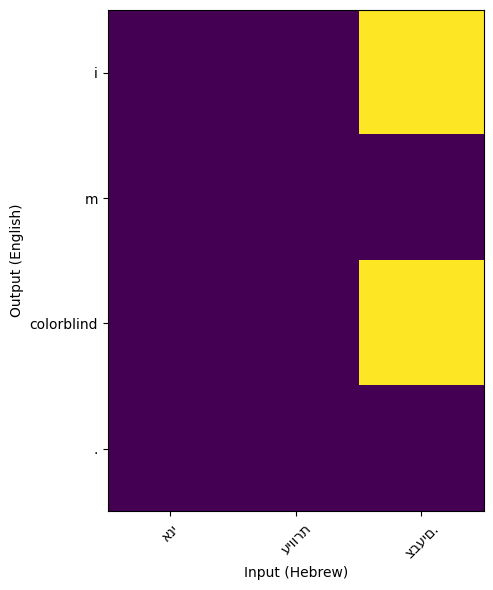

HE: אני בעד הצעתך בכל לבי.
GT: i m all for your suggestion .
PR: i m looking for you .


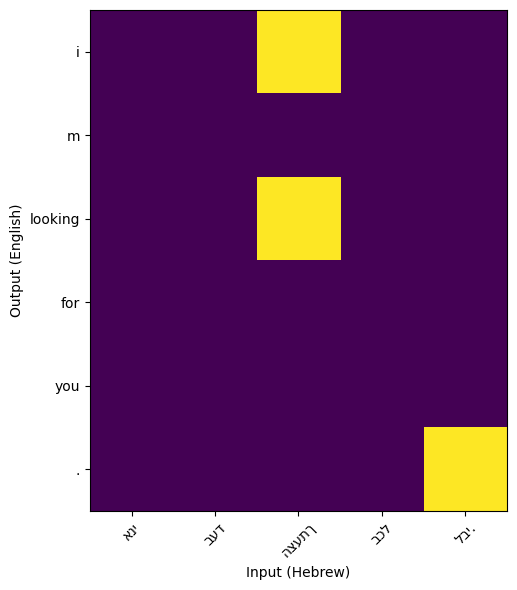

HE: אתה מסכן את החיים שלך.
GT: you re putting your life in danger .
PR: you re being foolish .


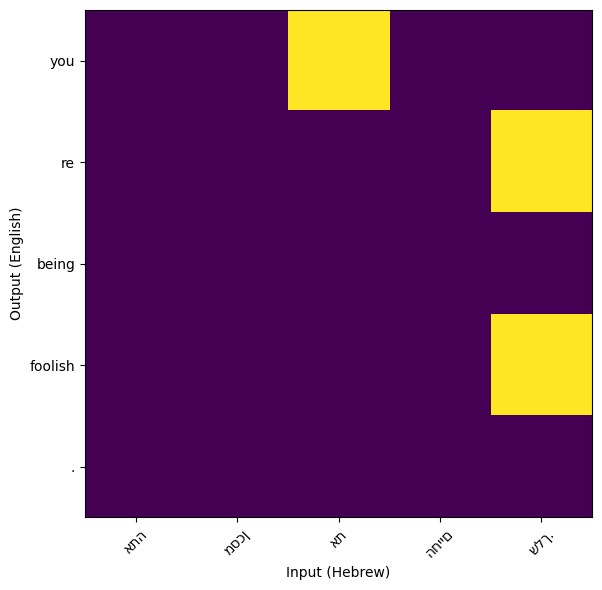

HE: הלכת לאיבוד, נכון?
GT: you are lost aren t you ?
PR: you re being transferred .


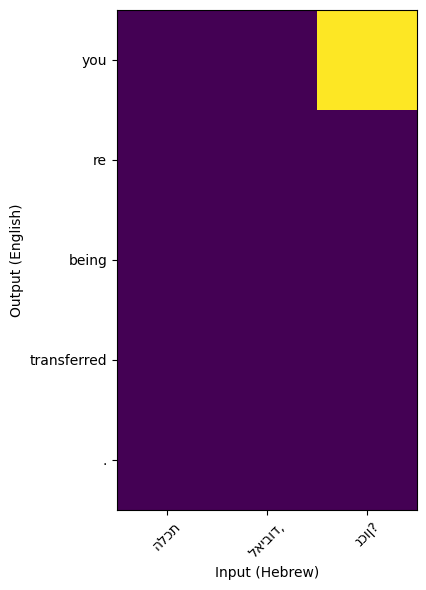

HE: היא זריזה מאד עם מסורים.
GT: she s very handy with a saw .
PR: she s very good at singing .


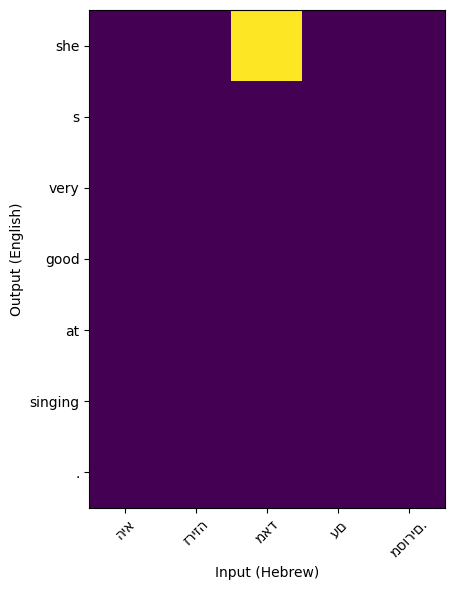

In [34]:
def evaluate_with_attention(pair, encoder, decoder):
    he, en = pair

    with torch.no_grad():
        src = sentence_to_tensor(src_vocab, he)
        enc_hidden = encoder.init_hidden()
        enc_outputs = torch.zeros(MAX_LENGTH, HIDDEN_SIZE, device=device)

        for i in range(src.size(0)):
            enc_out, enc_hidden = encoder(src[i], enc_hidden)
            if i < MAX_LENGTH:
                enc_outputs[i] = enc_out[0, 0]

        dec_input = torch.tensor([[SOS]], device=device)
        dec_hidden = enc_hidden

        decoded_words = []
        attentions = []

        for _ in range(MAX_LENGTH):
            dec_out, dec_hidden, attn_weights = decoder(
                dec_input, dec_hidden, enc_outputs
            )

            topv, topi = dec_out.topk(1)
            idx = topi.item()

            attentions.append(attn_weights.squeeze(0).cpu())

            if idx == EOS:
                break

            decoded_words.append(tgt_vocab.idx2word[idx])
            dec_input = topi.detach()

        return decoded_words, torch.stack(attentions)


def plot_attention(input_sentence, output_words, attentions):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    ax.imshow(attentions[:len(output_words), :len(input_sentence.split())],
              cmap="viridis")

    ax.set_xticks(range(len(input_sentence.split())))
    ax.set_yticks(range(len(output_words)))

    ax.set_xticklabels(input_sentence.split(), rotation=45)
    ax.set_yticklabels(output_words)

    ax.set_xlabel("Input (Hebrew)")
    ax.set_ylabel("Output (English)")

    plt.tight_layout()
    plt.show()


print("\n--- Attention plots (5 random sentences) ---\n")

for pair in random.sample(filtered_pairs, 5):
    he, en = pair
    output_words, attn = evaluate_with_attention(pair, encoder, decoder)

    print("HE:", he)
    print("GT:", en)
    print("PR:", " ".join(output_words))

    plot_attention(he, output_words, attn)

|3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?


The model learns some basic lexical and syntactic patterns and is able to correctly translate short and frequent sentences.
However, a loss of 0.717 combined with qualitative evaluation shows that the model often produces fluent but semantically incorrect translations.
The attention visualizations reveal weak and inconsistent alignments, indicating that the model does not fully capture source–target dependencies.
Overall, the model partially works but lacks robustness, generalization, and semantic understanding.

4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [35]:

    # ----------------------------
    # Hyperparameters (from notebook)
    # ----------------------------
    MAX_LENGTH = 10
    HIDDEN_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 0.01

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # ----------------------------
    # Filter eng_prefixes
    # ----------------------------
    eng_prefixes = (
        "i am ", "i m ",
        "he is", "he s ",
        "she is", "she s ",
        "you are", "you re ",
        "we are", "we re ",
        "they are", "they re "
    )

    def keep_pair(en: str, he: str) -> bool:
        return (
            len(en.split()) < MAX_LENGTH and
            len(he.split()) < MAX_LENGTH and
            en.startswith(eng_prefixes)
        )

    # sentence_pairs = [(en, he), ...]
    filtered_pairs = [(he, en) for (en, he) in sentence_pairs if keep_pair(en, he)]

    print("Filtered pairs:", len(filtered_pairs))
    print("Example:", filtered_pairs[0])

    # ----------------------------
    # Vocabulary
    # ----------------------------
    SOS = 0
    EOS = 1

    class Vocab:
        def __init__(self):
            self.word2idx = {}
            self.idx2word = {SOS: "<SOS>", EOS: "<EOS>"}
            self.counts = {}
            self.size = 2

        def add_sentence(self, sentence: str):
            for w in sentence.split():
                self.add_word(w)

        def add_word(self, word: str):
            if word not in self.word2idx:
                self.word2idx[word] = self.size
                self.idx2word[self.size] = word
                self.counts[word] = 1
                self.size += 1
            else:
                self.counts[word] += 1

    def sentence_to_tensor(vocab: Vocab, sentence: str):
        idxs = [vocab.word2idx[w] for w in sentence.split()]
        idxs.append(EOS)
        return torch.tensor(idxs, dtype=torch.long, device=device).view(-1, 1)

    # Build vocabularies
    src_vocab = Vocab()
    tgt_vocab = Vocab()

    for he, en in filtered_pairs:
        src_vocab.add_sentence(he)
        tgt_vocab.add_sentence(en)

    print("Hebrew vocab size:", src_vocab.size)
    print("English vocab size:", tgt_vocab.size)

    # ----------------------------
    # Encoder (GRU)
    # ----------------------------
    class Encoder(nn.Module):
        def __init__(self, vocab_size, hidden_dim):
            super().__init__()
            self.hidden_dim = hidden_dim
            self.embed = nn.Embedding(vocab_size, hidden_dim)
            self.gru = nn.GRU(hidden_dim, hidden_dim)

        def forward(self, x, hidden):
            emb = self.embed(x).view(1, 1, -1)
            out, hidden = self.gru(emb, hidden)
            return out, hidden

        def init_hidden(self):
            return torch.zeros(1, 1, self.hidden_dim, device=device)

    # ----------------------------
    # Attention Decoder
    # ----------------------------
    class AttnDecoder(nn.Module):
        def __init__(self, hidden_dim, vocab_size):
            super().__init__()
            self.embed = nn.Embedding(vocab_size, hidden_dim)
            self.attn = nn.Linear(hidden_dim * 2, MAX_LENGTH)
            self.combine = nn.Linear(hidden_dim * 2, hidden_dim)
            self.gru = nn.GRU(hidden_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, vocab_size)

        def forward(self, token, hidden, encoder_outputs):
            emb = self.embed(token).view(1, 1, -1)

            attn_weights = torch.softmax(
                self.attn(torch.cat((emb[0], hidden[0]), dim=1)),
                dim=1
            )

            context = torch.bmm(
                attn_weights.unsqueeze(0),
                encoder_outputs.unsqueeze(0)
            )

            combined = torch.cat((emb[0], context[0]), dim=1)
            combined = torch.relu(self.combine(combined)).unsqueeze(0)

            out, hidden = self.gru(combined, hidden)
            out = torch.log_softmax(self.out(out[0]), dim=1)

            return out, hidden, attn_weights

    # ----------------------------
    # One training step
    # ----------------------------
    def train_step(pair, encoder, decoder, enc_opt, dec_opt, criterion):
        he, en = pair

        enc_opt.zero_grad()
        dec_opt.zero_grad()

        src = sentence_to_tensor(src_vocab, he)
        tgt = sentence_to_tensor(tgt_vocab, en)

        enc_hidden = encoder.init_hidden()
        enc_outputs = torch.zeros(MAX_LENGTH, HIDDEN_SIZE, device=device)

        for i in range(src.size(0)):
            enc_out, enc_hidden = encoder(src[i], enc_hidden)
            if i < MAX_LENGTH:
                enc_outputs[i] = enc_out[0, 0]

        dec_input = torch.tensor([[SOS]], device=device)
        dec_hidden = enc_hidden

        loss = 0
        for t in range(tgt.size(0)):
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_outputs)
            loss += criterion(dec_out, tgt[t])
            dec_input = tgt[t]

        loss.backward()
        enc_opt.step()
        dec_opt.step()

        return loss.item() / tgt.size(0)

    # ----------------------------
    # Training loop
    # ----------------------------
    encoder = Encoder(src_vocab.size, HIDDEN_SIZE).to(device)
    decoder = AttnDecoder(HIDDEN_SIZE, tgt_vocab.size).to(device)

    enc_opt = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
    dec_opt = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)
    criterion = nn.NLLLoss()

    for epoch in range(1, EPOCHS + 1):
        random.shuffle(filtered_pairs)
        total_loss = 0

        for pair in filtered_pairs:
            total_loss += train_step(pair, encoder, decoder, enc_opt, dec_opt, criterion)

        print(f"Epoch {epoch}/{EPOCHS} | loss = {total_loss / len(filtered_pairs):.4f}")

    print("Training completed.")

Device: cpu
Filtered pairs: 9225
Example: ('אני בסדר.', 'i m ok .')
Hebrew vocab size: 7359
English vocab size: 3050
Epoch 1/50 | loss = 2.5455
Epoch 2/50 | loss = 1.9090
Epoch 3/50 | loss = 1.5335
Epoch 4/50 | loss = 1.2296
Epoch 5/50 | loss = 0.9636
Epoch 6/50 | loss = 0.7443
Epoch 7/50 | loss = 0.5552
Epoch 8/50 | loss = 0.4000
Epoch 9/50 | loss = 0.2760
Epoch 10/50 | loss = 0.1797
Epoch 11/50 | loss = 0.1192
Epoch 12/50 | loss = 0.0837
Epoch 13/50 | loss = 0.0689
Epoch 14/50 | loss = 0.0600
Epoch 15/50 | loss = 0.0511
Epoch 16/50 | loss = 0.0479
Epoch 17/50 | loss = 0.0446
Epoch 18/50 | loss = 0.0416
Epoch 19/50 | loss = 0.0404
Epoch 20/50 | loss = 0.0391
Epoch 21/50 | loss = 0.0370
Epoch 22/50 | loss = 0.0358
Epoch 23/50 | loss = 0.0352
Epoch 24/50 | loss = 0.0344
Epoch 25/50 | loss = 0.0343
Epoch 26/50 | loss = 0.0330
Epoch 27/50 | loss = 0.0331
Epoch 28/50 | loss = 0.0323
Epoch 29/50 | loss = 0.0320
Epoch 30/50 | loss = 0.0319
Epoch 31/50 | loss = 0.0305
Epoch 32/50 | loss = 0.0

In [36]:
print("\n--- Random evaluation after changing to HIDDEN_LAYER = 256 (20 sentences) ---\n")

correct = 0
total = 20

samples = random.sample(filtered_pairs, total)

for he, en in samples:
    pred = evaluate((he, en), encoder, decoder)

    is_correct = (pred.strip() == en.strip())
    if is_correct:
        correct += 1

    print("HE:", he)
    print("GT:", en)
    print("PR:", pred)
    print("✔ CORRECT" if is_correct else "✘ WRONG")
    print("-" * 40)

print("\n================= EVALUATION SUMMARY =================")
print(f"Correct predictions: {correct} / {total}")
print(f"Accuracy on sample: {correct / total:.2%}")
print("======================================================\n")


--- Random evaluation after changing to HIDDEN_LAYER = 256 (20 sentences) ---

HE: אתה תמים.
GT: you re naive .
PR: you re naive .
✔ CORRECT
----------------------------------------
HE: אני לא מתכוונת להתקוטט איתך.
GT: i m not going to fight you .
PR: i m not going to fight you .
✔ CORRECT
----------------------------------------
HE: אלה הן המכוניות שלנו.
GT: they are our cars .
PR: they are our cars .
✔ CORRECT
----------------------------------------
HE: אני לא מזוין.
GT: i m unarmed .
PR: i m unarmed .
✔ CORRECT
----------------------------------------
HE: יש לה מזג זועף.
GT: she is ill natured .
PR: she is ill natured .
✔ CORRECT
----------------------------------------
HE: אנו עסוקים מאד מאד.
GT: we re very very busy .
PR: we re very very busy .
✔ CORRECT
----------------------------------------
HE: אני יגעה.
GT: i m tired .
PR: i m tired .
✔ CORRECT
----------------------------------------
HE: אני חסרת הגנה.
GT: i m defenseless .
PR: i m defenseless .
✔ CORRECT
-----------------


--- Attention plots after changing to HIDDEN_LAYER = 256 (5 random sentences) ---

HE: אנו מחרידים.
GT: we re horrible .
PR: we re horrible .


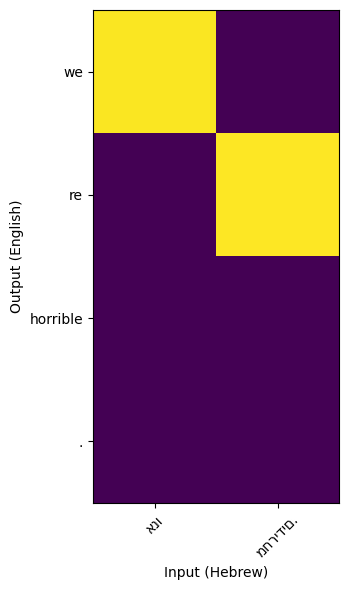

HE: אני מפחד מרעידות אדמה.
GT: i m afraid of earthquakes .
PR: i m afraid of earthquakes .


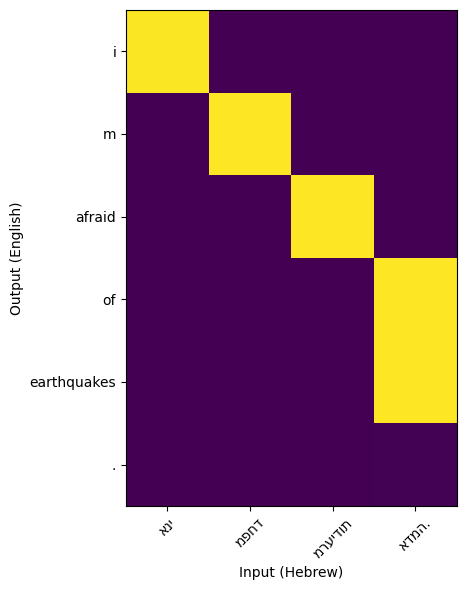

HE: אני מרוצה מאד שעשיתי את זה.
GT: i m very glad that i did that .
PR: i m very glad that i did that .


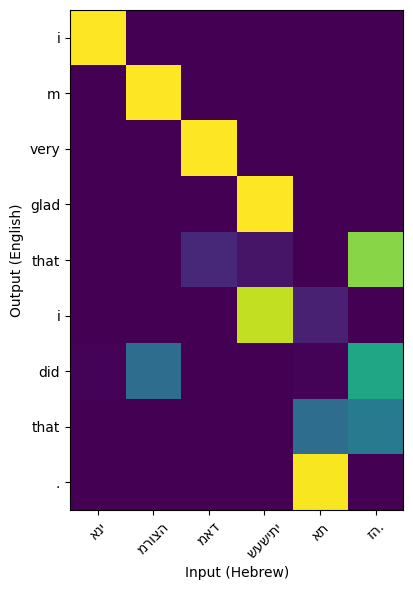

HE: הם צעירים ובריאים.
GT: they re young and healthy .
PR: they re young and healthy .


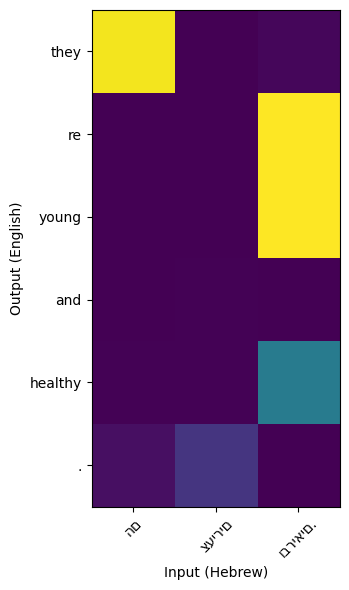

HE: אני לא מדברת על תום.
GT: i m not talking about tom .
PR: i m not talking about tom .


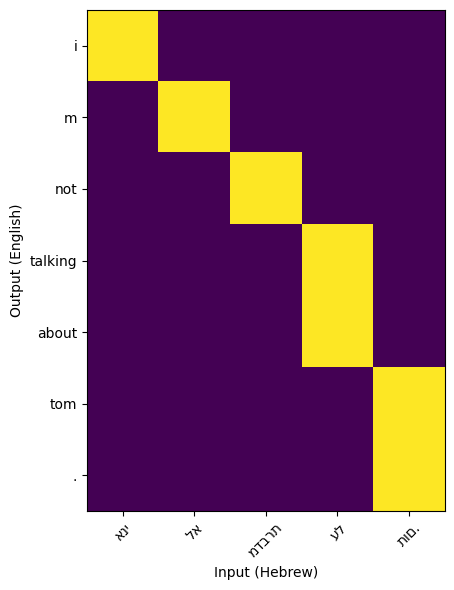

In [39]:
print("\n--- Attention plots after changing to HIDDEN_LAYER = 256 (5 random sentences) ---\n")

for pair in random.sample(filtered_pairs, 5):
    he, en = pair
    output_words, attn = evaluate_with_attention(pair, encoder, decoder)

    print("HE:", he)
    print("GT:", en)
    print("PR:", " ".join(output_words))

    plot_attention(he, output_words, attn)

To improve upon the baseline model, I increased the hidden size of the encoder and attention-based decoder from 128 to 256. This significantly increased the model’s capacity to represent semantic information. As a result, the training loss dropped from approximately 0.72 to 0.03, and qualitative evaluation shows a substantial improvement in translation quality. The model produces fluent and semantically accurate translations with far fewer generic or unrelated outputs. This suggests that the larger hidden representation allows the model to better capture the structure and meaning of the input sentences.